In [1]:
import os
import zipfile
import time
import datetime

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import cv2
from PIL import Image

import numpy as np

from keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, \
                         Activation, ReLU, MaxPooling2D
from keras import layers
from keras.models import Model
from keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

import keras.backend as K
from keras.utils import plot_model
from keras import optimizers

import tensorflow as tf

from prettytable import PrettyTable

import urllib


C:\Users\Naina\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\Naina\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Naina\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


This code sets a fixed seed (42) for NumPy and TensorFlow to ensure reproducibility in random number generation during subsequent operations.

In [2]:
import numpy as np
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


These are temporary configuration settings for a neural style transfer model:

In [3]:
##############TEMPORARY CONSTANTS#####################
net_name = 'draft_512'

height = 512 # 256x256 in original article
width = 512

batch_size = 4
steps_per_epoch = 5000 # 20000 in original article
epochs = 2

learning_rate = 1e-3 

verbose_iter = 100 #set how often show training info and save test picture

# loss weigts
content_w = 2500  
style_w1 = 0.1
style_w2 = 0.1
style_w3 = 0.2
style_w4 = 0.1
tv_w = 0.01    
output_w = 0

style_img_path = '../../../Dataset/style/artist/Pablo_Picasso_96.jpg'
test_content_img_path = '../../../Dataset/test_content/test/2691116471_6c49a0041a_m.jpg' # use it to check training process
test_content_imgs_save_path = '../../../Dataset/temp' # for generated images during training loop

style_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
content_layer = 'block3_conv3'

# model_saving_path = '../../../Fast_Neural_Style_Transfer-master/Fast_Neural_Style_Transfer-master/'

## Train model

### Data downloading

In [4]:
# zip_file_path = '/content/train2014.zip'
# unzipped_train_path = '/content/coco2014_train/train2014'

dir_path = '../../../Dataset/content/Train'

In [5]:
# create complete file pathes
files_path_list = [os.path.join(dir_path, file_name) for file_name in os.listdir(dir_path)]
files_path_list[:3]

['../../../Dataset/content/Train\\10165505323_f702f86cb7.jpg',
 '../../../Dataset/content/Train\\11033166486_5bd51d30e0_m.jpg',
 '../../../Dataset/content/Train\\11033192543_b3e481227b_m.jpg']

In [6]:
print('Samples amount:', len(dir_path))

Samples amount: 30


This code randomly selects and displays an image from a specified directory

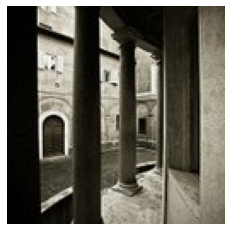

In [7]:
import os
import numpy as np
import cv2

# Specify the directory path
dir_path = "../../../Dataset/content/Train"

# Get a list of all filenames in the directory
file_list = os.listdir(dir_path)

# Generate a random index
random_index = np.random.randint(0, len(file_list))

# Construct the full file path
img_path = os.path.join(dir_path, file_list[random_index])

# Load the image
img_example = cv2.imread(img_path)

# Check if the image was loaded successfully
if img_example is not None:
    # Convert BGR to RGB (OpenCV uses BGR by default)
    img_example_rgb = cv2.cvtColor(img_example, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.imshow(img_example_rgb)
    plt.axis('off')  # Turn off axis labels
    plt.show()
else:
    print(f"Error: Unable to load image at index {random_index}")


### Setting up model functions

This code defines three helper functions for neural style transfer:

1. **`gram_matrix(x)`**: Calculates the Gram matrix for a given input tensor `x`. The Gram matrix is a measure of the correlation between different filter responses in a convolutional layer.

2. **`dummy_loss(y_true, y_pred)`**: A placeholder loss function used for initializing loss functions and compiling the model. It returns `y_pred` and doesn't impact the optimization process.

3. **`zero_loss(y_true, y_pred)`**: A loss function that initializes VGG-16 inputs by zero. It returns a tensor of zeros and is used as an auxiliary loss for specific layers during training.

These functions are crucial for the neural style transfer model and help in defining custom losses and initializing certain aspects of the model.

In [8]:
# Helper function

def gram_matrix(x):
    '''
    Calculate Gram matrix 
    http://pmpu.ru/vf4/dets/gram
    '''
    # K.permute_dimensions - Permutes axes in a tensor. https://www.tensorflow.org/api_docs/python/tf/keras/backend/permute_dimensions
    # K.batch_flatten - Turn a nD tensor into a 2D tensor with same 0th dimension. https://www.tensorflow.org/api_docs/python/tf/keras/backend/batch_flatten
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def dummy_loss(y_true, y_pred):
  '''
  Use to initialize loss functions and compile model.
  Input variables y_true, y_pred are demanded by keras, even if they doesn`t return
  Read more here https://towardsdatascience.com/advanced-keras-constructing-complex-custom-losses-and-metrics-c07ca130a618
  '''
  return y_pred

def zero_loss(y_true, y_pred):
  '''
  Initialize VGG-16 inputs by zero
  '''
  return K.variable(np.zeros(1,))

These custom loss functions for neural style transfer include:

1. **`get_content_loss(inputs, batch_size)`**:
   - Computes content loss between VGG-16 layer activation (`vgg_c3`) and content activation.
   - Normalizes the sum of squared differences by spatial dimensions.

2. **`get_style_loss(activations, **kwargs)`**:
   - Calculates style loss between layer activation (`layer_activation`) and style activation.
   - Utilizes Gram matrices and normalizes by the square of spatial dimensions.

3. **`get_tv_loss(x, **kwargs)`**:
   - Computes total variation loss to reduce puzzling effects.
   - Takes spatial dimensions into account for loss computation.

In [9]:
# Loss functions

import keras.backend as K

def get_content_loss(inputs, batch_size):
    vgg_c3, content_activation = inputs
    H, W, C = K.int_shape(content_activation)[1:]

    loss = 0
    for idx in range(batch_size):
        loss += K.sum(K.square(vgg_c3[idx] - content_activation[idx])) / (H * W * C)

    return loss / batch_size



def get_style_loss(activations, **kwargs):
    '''
    Calculate style loss.
    '''
    layer_activation, style_activation = activations
    batch_size = kwargs.get('batch_size', 1)  # Default value is 1 if batch_size is not provided

    shape = style_activation.shape.dims
    H, W, C = shape[1], shape[2], shape[3]

    loss = K.variable(0)
    for idx in range(batch_size):
        layer_gram = gram_matrix(layer_activation[idx])
        style_gram = gram_matrix(style_activation[idx])
        loss = loss + K.sum(K.square(layer_gram - style_gram)) / ((H * W * C).value**2)

    return loss



def get_tv_loss(x, **kwargs):
  '''
   Calculate total variation loss. Reduce puzzling effect
  '''
  height = kwargs['height']
  width = kwargs['width']
  a = K.square(x[:, :height - 1, :width - 1, :] - 
               x[:, 1:, :width - 1, :])
  b = K.square(x[:, :height - 1, :width - 1, :] - 
               x[:, :height - 1, 1:, :])
  print(a.shape, b.shape)
  return K.sum(K.pow(a+b, 1.25))

### Setting up models architectures and adding VGG16 frozen weights. Compile model.

This function defines a residual block for a neural network with the following key steps:

- Applies two convolutional layers with batch normalization and ReLU activation to the input.
- Creates a shortcut connection.
- Adds the shortcut and processed tensor.
- Applies ReLU activation to the sum.

The output is the tensor of the residual block.

In [10]:
def residual_block(y, _nb_channels = 128, _strides = (1, 1), name_number = 1):
  shortcut = y

  #forward pass
  y = Conv2D(filters = _nb_channels, kernel_size = (3, 3), 
             strides = _strides, padding = 'same', 
             name = 're_conv1_{}'.format(name_number))(y)
  y = BatchNormalization(name = 're_batch1_{}'.format(name_number))(y)
  y = ReLU(name = 're_relu1_{}'.format(name_number))(y)

  y = Conv2D(filters = _nb_channels, kernel_size = (3, 3), 
             strides = _strides, padding = 'same',
              name = 're_conv2_{}'.format(name_number))(y)
  y = BatchNormalization(name = 're_batch2_{}'.format(name_number))(y)

  #adding shortcut
  y = layers.add([shortcut, y])
  y = ReLU(name = 're_relu2_{}'.format(name_number))(y)

  return y

This Keras custom layer, `OutputScale`, scales the input tensor by a fixed factor of 150. It has no trainable parameters, and the output shape is the same as the input.

In [11]:
class OutputScale(layers.Layer):

    def __init__(self, **kwargs):
        super(OutputScale, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        return x * 150

    def compute_output_shape(self, input_shape):
        return input_shape

In [13]:
from IPython.display import display, HTML

html_code = """
<p float="left">
  <img src="https://raw.githubusercontent.com/Gooogr/Keras_Fast_Style_Transfer/master/schemes/Complete%20scheme.png" width="500" />
  <img src="https://raw.githubusercontent.com/Gooogr/Keras_Fast_Style_Transfer/master/schemes/VGG16.png" width="500" />
  <img src="https://raw.githubusercontent.com/Gooogr/Keras_Fast_Style_Transfer/master/schemes/Image%20Transform%20Net.png" width="500" />
</p>
"""

display(HTML(html_code))


Initialize model structure

In [14]:
from keras import backend as K

K.clear_session()



In [15]:
from keras import backend as K
from keras.layers import Layer

This function defines a complex neural network model for training in the context of neural style transfer. Here's a summary:

- **Input**:
  - `height`, `width`: Input image dimensions.
  - `batch_size`: Batch size.

- **Encoder Block**:
  - Three convolutional sub-blocks (`c1`, `c2`, `c3`).
  - Five residual sub-blocks (`r1` to `r5`).
  - Two deconvolutional sub-blocks (`d1`, `d2`).
  - Final convolutional block (`c4`) with hard sigmoid activation.

- **VGG-16 Block**:
  - Sub-blocks 1 to 4 with max-pooling.
  - Content loss computed for the activation from sub-block 3.

- **Style Loss Layer**:
  - Custom layer (`StyleLossLayer`) to compute style losses for multiple layers.

- **Total Variation Loss**:
  - Computes total variation loss for regularization.

- **Model Output**:
  - The model has multiple outputs: content loss, style losses for different layers, total variation loss, and the final stylized image (`c4`).

- **Usage of Custom Layers**:
  - The `StyleLossLayer` is utilized to calculate style losses for different VGG-16 layers.

- **Model Definition**:
  - The final Keras model is constructed using the `Model` class.

This model is designed for training, considering content and style losses, total variation regularization, and the overall architecture for neural style transfer.

In [16]:
def get_training_model(height, width, batch_size):
  '''
  Create training model (with VGG-16 part).
  Input:
    height - input image height
    width - input image width
    batch_size - batch size
  Output:
    Non-compiled Keras model
  '''
  model_input = Input(shape = (height, width, 3), name = 'model_input')

  ### Autoencoder block ###
  # Convolution sub-blocks
  c1 = Conv2D(32, (9, 9), strides = 1, padding = 'same', name = 'conv_1')(model_input)
  c1 = BatchNormalization(name = 'norm_1')(c1)
  c1 = ReLU(name = 'relu_1')(c1)
  
  c2 = Conv2D(64, (3, 3), strides = 2, padding = 'same', name = 'conv_2')(c1)
  c2 = BatchNormalization(name = 'norm_2')(c2)
  c2 = ReLU(name = 'relu_2')(c2)

  c3 = Conv2D(128, (3, 3), strides = 2, padding = 'same', name = 'conv_3')(c2)
  c3 = BatchNormalization(name = 'norm_3')(c3)
  c3 = ReLU(name = 'relu_3')(c3)

  # Residual sub-blocks
  r1 = residual_block(c3, name_number = 1)
  r2 = residual_block(r1, name_number = 2)
  r3 = residual_block(r2, name_number = 3)
  r4 = residual_block(r3, name_number = 4)
  r5 = residual_block(r4, name_number = 5)

  # Deconvolution sub-blocks
  d1 = Conv2DTranspose(64, (3, 3), strides = 2, padding='same', name = 'conv_4')(r5)
  d1 = BatchNormalization(name = 'norm_4')(d1)
  d1 = ReLU(name = 'relu_4')(d1)

  d2 = Conv2DTranspose(32, (3, 3), strides = 2, padding='same', name = 'conv_5')(d1)
  d2 = BatchNormalization(name = 'norm_5')(d2)
  d2 = ReLU(name = 'relu_5')(d2)

  c4 = Conv2D(3, (9, 9), strides = 1, padding = 'same', name = 'conv_6')(d2)
  c4 = BatchNormalization(name = 'norm_6')(c4)
  c4 = Activation(activation = 'hard_sigmoid', name = 'hard_sigmoid_1')(c4) #hard sigmoid computes faster then sigmoid
  c4 = OutputScale(name = 'model_output')(c4) 

  ### Content and style activation inputs
  #shapes correspond to VGG16 layers. Look on scheme of activations exits.
  content_activation = Input(shape = (height//4, width//4, 256))  #(64, 64, 256)

  style_activation_1 = Input(shape = (height, width, 64))         #(256, 256, 64)
  style_activation_2 = Input(shape = (height//2, width//2, 128))  #(128, 128, 128)
  style_activation_3 = Input(shape = (height//4, width//4, 256))  #(64, 64, 256)
  style_activation_4 = Input(shape = (height//8, width//8, 512))  #(32, 32, 512)

  ### VGG-16 block ###
  # Sub-block 1
  # Sub-block 1
  vgg_c1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(c4)
  vgg_c1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(vgg_c1)
  vgg_c1 = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(vgg_c1)

  # Sub-block 2
  vgg_c2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(vgg_c1)
  vgg_c2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(vgg_c2)
  vgg_c2 = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(vgg_c2)

  # Sub-block 3
  vgg_c3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(vgg_c2)
  vgg_c3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(vgg_c3)
  vgg_c3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(vgg_c3)

  content_loss = layers.Lambda(lambda x: get_content_loss(x, batch_size),
                             output_shape=(1,), name='content_loss')([vgg_c3, content_activation])


  vgg_c3 = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(vgg_c3)

  # Sub-block 4
  vgg_c4 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(vgg_c3)
  vgg_c4 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(vgg_c4)
  vgg_c4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(vgg_c4)

  ### Total variation loss ###
  class StyleLossLayer(Layer):
    def __init__(self, **kwargs):
        super(StyleLossLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(StyleLossLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        layer_activation, style_activation = inputs
        batch_size = K.shape(layer_activation)[0]
        shape = style_activation.shape.dims
        H, W, C = shape[1], shape[2], shape[3]

        loss = K.variable(0)
        for idx in range(batch_size):
            layer_gram = gram_matrix(layer_activation[idx])
            style_gram = gram_matrix(style_activation[idx])
            loss = loss + K.sum(K.square(layer_gram - style_gram)) / ((H * W * C).value**2)

        return loss

    def compute_output_shape(self, input_shape):
        return (1,)

# ... (previous code)

# Usage in your model:
  style_loss1 = StyleLossLayer(name='style_loss1')([vgg_c1, style_activation_1])
  style_loss2 = StyleLossLayer(name='style_loss2')([vgg_c2, style_activation_2])
  style_loss3 = StyleLossLayer(name='style_loss3')([vgg_c3, style_activation_3])
  style_loss4 = StyleLossLayer(name='style_loss4')([vgg_c4, style_activation_4])


  total_variation_loss = layers.Lambda(get_tv_loss, output_shape=(1,), name='tv_loss',
                                      arguments={'width': width, 'height': height})(c4)

  ### Create model ###
  model = Model(inputs = [model_input, content_activation, style_activation_1, 
                          style_activation_2, style_activation_3, style_activation_4], 
                outputs = [content_loss, style_loss1, style_loss2, style_loss3, 
                          style_loss4, total_variation_loss, c4])
  return model

In [17]:
def get_pred_model(height, width):
  '''
  Create simplified autoencoder model, only for predictions
  Input:
    height - input image height
    width - input image width
    batch_size - batch size
  Output:
    Non-compiled Keras model
  '''
  model_input = Input(shape=(height, width, 3), name='model_input')

  ### Autoencoder block ###
  # Convolution sub-blocks
  c1 = Conv2D(32, (9, 9), strides=1, padding='same', name='conv_1')(model_input)
  c1 = BatchNormalization(name='norm_1')(c1)
  c1 = ReLU(name='relu_1')(c1)

  c2 = Conv2D(64, (3, 3), strides = 2, padding = 'same', name = 'conv_2')(c1)
  c2 = BatchNormalization(name = 'norm_2')(c2)
  c2 = ReLU(name = 'relu_2')(c2)

  c3 = Conv2D(128, (3, 3), strides = 2, padding = 'same', name = 'conv_3')(c2)
  c3 = BatchNormalization(name = 'norm_3')(c3)
  c3 = ReLU(name = 'relu_3')(c3)

  # Residual sub-blocks
  r1 = residual_block(c3, name_number = 1)
  r2 = residual_block(r1, name_number = 2)
  r3 = residual_block(r2, name_number = 3)
  r4 = residual_block(r3, name_number = 4)
  r5 = residual_block(r4, name_number = 5)

  # Deconvolution sub-blocks
  d1 = Conv2DTranspose(64, (3, 3), strides = 2, padding='same', name = 'conv_4')(r5)
  d1 = BatchNormalization(name = 'norm_4')(d1)
  d1 = ReLU(name = 'relu_4')(d1)

  d2 = Conv2DTranspose(32, (3, 3), strides = 2, padding='same', name = 'conv_5')(d1)
  d2 = BatchNormalization(name = 'norm_5')(d2)
  d2 = ReLU(name = 'relu_5')(d2)

  c4 = Conv2D(3, (9, 9), strides = 1, padding = 'same', name = 'conv_6')(d2)
  c4 = BatchNormalization(name = 'norm_6')(c4)
  c4 = Activation(activation = 'hard_sigmoid', name = 'hard_sigmoid_1')(c4) #hard sigmoid computes faster then sigmoid
  c4 = OutputScale(name = 'model_output')(c4) 

  model = Model(inputs = model_input, outputs = c4)

  return model

In [18]:
model = get_training_model(height, width, batch_size)

(None, 511, 511, 3) (None, 511, 511, 3)


Let's load imagenet weights in our VGG16 model's part and frozen them

In [19]:
model_layers = {layer.name: layer for layer in model.layers}

vgg_imagenet = vgg16.VGG16(weights = 'imagenet', include_top = False)
vgg_imagenet_layers = {layer.name: layer for layer in vgg_imagenet.layers}

for layer in vgg_imagenet.layers:
  if layer.name in model_layers:
    # load imagenet weights in model layer
    model_layers[layer.name].set_weights(vgg_imagenet_layers[layer.name].get_weights())
    # froze layer
    model_layers[layer.name].trainable = False


Compile model

In [20]:
model_loss_weights = [content_w, style_w1, style_w2, style_w3, style_w4, tv_w, output_w]
model_optimizer = optimizers.Adam(lr = learning_rate) 
                                  
model_loss = {'content_loss': dummy_loss, 'style_loss1': dummy_loss, 'style_loss2': dummy_loss,
              'style_loss3': dummy_loss, 'style_loss4': dummy_loss, 'tv_loss': dummy_loss, 
              'model_output': zero_loss}

model.compile(loss = model_loss, optimizer = model_optimizer, loss_weights = model_loss_weights)

C:\Users\Naina\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:

model_summary = PrettyTable()
model_summary.field_names = ['layer name', 'input shape', 'output shape']

for layer in model.layers:
  model_summary.add_row([layer.name, layer.input_shape, layer.output_shape])
print(model_summary)


+----------------+------------------------------------------------+-------------------------+
|   layer name   |                  input shape                   |       output shape      |
+----------------+------------------------------------------------+-------------------------+
|  model_input   |             [(None, 512, 512, 3)]              |  [(None, 512, 512, 3)]  |
|     conv_1     |              (None, 512, 512, 3)               |   (None, 512, 512, 32)  |
|     norm_1     |              (None, 512, 512, 32)              |   (None, 512, 512, 32)  |
|     relu_1     |              (None, 512, 512, 32)              |   (None, 512, 512, 32)  |
|     conv_2     |              (None, 512, 512, 32)              |   (None, 256, 256, 64)  |
|     norm_2     |              (None, 256, 256, 64)              |   (None, 256, 256, 64)  |
|     relu_2     |              (None, 256, 256, 64)              |   (None, 256, 256, 64)  |
|     conv_3     |              (None, 256, 256, 64)        

### Helper functions for model training

These functions are for image preprocessing and deprocessing in neural style transfer:

- **`preprocess_img(img_path, img_height, img_width, resize_img=True)`**:
  - Loads and preprocesses an image for VGG16, optionally resizing it.

- **`deprocess_img(x, height, width)`**:
  - Deprocesses the model output into an image compatible with OpenCV. Adjusts pixel values and removes mean values introduced during preprocessing.

In [22]:
# Image processing/deprocessing functions

def preprocess_img(img_path, img_height, img_width, resize_img = True):
  ''' 
  Convert raw image to [1, img_width, imh_height, 3] image prepared to VGG16
  '''
  if resize_img:
    img = load_img(img_path, target_size = (img_height, img_width))
  else:
     img = load_img(img_path)
  img = img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  img = vgg16.preprocess_input(img)
  return img


def deprocess_img(x, height, width): # Was copied from training part
  '''
  Deprocess  model output into image. Image compatible with OpenCV.
  Input:
    x - raw model output
    height - wishful image height
    width - wishful image width
  Output:
    img - result image, ready for OpenCV
  '''
  
  x = x.reshape([height, width, 3])
  # Remove zero-pixel mean value
  # Read more here: https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  # BGR -> RGB
  #x = x[:, :, ::-1] # Made a color error in OpenCV
  img = np.clip(x, 0, 255).astype('uint8')
  return img

In [23]:
# Helper function to get initial activation

def get_func_extract_vgg_activations(layer_name, width, height):
  '''
  Return function which input is a placeholder with shape [1, height, weight, 3]
  and output is selected layer output of VGG16 newtwork.
  This layer can be feeded through the placeholder.
  '''
  tensor = K.placeholder([1, height, width, 3])
  temp_model = vgg16.VGG16(input_tensor = tensor, weights = 'imagenet', 
                           include_top = False)
  for layer in temp_model.layers:
    if layer.name == layer_name:
      layer.trainable = False
      return K.function([tensor], [layer.output])

def expand_batch_input(batch_size, initial_input):
  '''
  Expand batch dimension of selected input by copy-paste initial matrix.
  [1, 256, 256, 3] -> [4, 256,  256, 3] if butch_size = 4
  Input:
    "batch_size" - nessesary amount of batches 
    "initial_input" - input that should be expanded
  Output:
    expanded input
  '''
  expanded_input = initial_input.copy()
  for step in range(batch_size - 1):
    expanded_input = np.append(expanded_input, initial_input, axis = 0)
  return expanded_input

These functions are for printing training and testing information during the neural style transfer process:

- **`print_training_loss(history_data)`**:
  - Prints the current training loss details, including content loss, style losses, and total variation loss.

- **`print_test_info(verbose_result)`**:
  - Prints the loss information for the test image during the training loop, including the current sum loss, content loss, style losses, and total variation loss.

In [24]:
def print_training_loss(history_data):
  '''
  Print out current loss.
  input:
    history_data  - keras History object. Get it from model_name.history .
  output:
    None
  '''
  #print('****************************************')
  print('Training loss details')
  print('Content loss: {}'.format(history.history['content_loss_loss'][0]))
  print('Style loss_1: {}, Style loss_2: {}'.format(history.history['style_loss1_loss'][0], history.history['style_loss2_loss'][0]))
  print('Style loss_3: {}, Style loss_4: {}'.format(history.history['style_loss3_loss'][0], history.history['style_loss4_loss'][0]))
  print('Total variation loss: {}'.format(history.history['tv_loss_loss'][0]))
  print('----------------------------------------')


def print_test_info(verbose_result):
  '''
  Print out loss information of the test image during the training loop.
  input:
    verbose_result - current model`s prediction. Contain losses information and output image.
  output:
    None
  '''
  loss_list = []
  loss_list.append(verbose_result[0][0] * content_w) 
  loss_list.append(verbose_result[1][0] * style_w1)
  loss_list.append(verbose_result[2][0] * style_w2) 
  loss_list.append(verbose_result[3][0] * style_w3) 
  loss_list.append(verbose_result[4][0] * style_w4) 
  loss_list.append(verbose_result[5][0] * tv_w) 
  current_loss = sum(loss_list)
  print('----------------------------------------')
  print('Current test image losses')
  print('Current sum loss: {}'.format(current_loss))
  print('Losses parts:')
  print('Content loss: {}'.format(loss_list[0]))
  print('Style loss_1: {}, Style loss_2: {}, \nStyle loss_3: {}, Style loss_4: {}'.format(loss_list[1], loss_list[2], loss_list[3], loss_list[4]))
  print('Total variation loss: {}'.format(loss_list[5]))
  #print('----------------------------------------')

### Model training

In [25]:
## Getting activation to fit them in our model
# Get style activations
style_tensor = preprocess_img(style_img_path, height, width)
style_act = []
for layer_name in tqdm_notebook(style_layers):
    style_function = get_func_extract_vgg_activations(layer_name, width, height)
    style_activation = expand_batch_input(batch_size, style_function([style_tensor])[0])
    style_act.append(style_activation)

# Get content activations for test image
content_test_tensor = preprocess_img(test_content_img_path, height, width)
content_function = get_func_extract_vgg_activations(content_layer, width, height)
content_test_activation = expand_batch_input(batch_size, content_function([content_test_tensor])[0])
content_test = expand_batch_input(batch_size, content_test_tensor) 


C:\Users\Naina\AppData\Local\Temp/ipykernel_12112/1571488650.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for layer_name in tqdm_notebook(style_layers):


  0%|          | 0/4 [00:00<?, ?it/s]

The provided code defines a custom data generator (`CustomDataGenerator`) using the Keras `Sequence` class for training a neural style transfer model. It reads and preprocesses images from a specified directory in batches, generating input and output data for training. This generator is tailored to the requirements of a neural style transfer model.

In [35]:
import keras
import glob
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence

datagen = ImageDataGenerator()
dummy_input = expand_batch_input(batch_size, np.array([0.0]))
start_time = time.time()
summ_time = 0

class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, dir_path, batch_size, height, width):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.height = height
        self.width = width
        self.image_files = glob.glob(os.path.join(dir_path, 'train', '*.*'))
        self.num_samples = len(self.image_files)

    def __len__(self):
        return (self.num_samples + self.batch_size - 1) // self.batch_size

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_files = self.image_files[start:end]

        x = [cv2.imread(file) for file in batch_files]
        x = [cv2.resize(img, (self.width, self.height)) for img in x]
        x = np.array(x)

        x = vgg16.preprocess_input(x)
        content_act = content_function([x])[0]
        dummy_input = expand_batch_input(self.batch_size, np.array([0.0]))
        y = [dummy_input] * 6 + [x]
        
        return [x, content_act, style_act[0], style_act[1], style_act[2], style_act[3]], y


In [37]:
### Save results ###
import os

# Define the path where you want to save the model weights
model_saving_path = '../../../Dataset/temp'

# Ensure the directory exists, create it if necessary
os.makedirs(model_saving_path, exist_ok=True)

pred_model = get_pred_model(height, width)

# fill pred_model by trained weights
training_model_layers = {layer.name: layer for layer in model.layers}
for layer in tqdm_notebook(pred_model.layers):
  if layer.name in training_model_layers.keys():
    layer.set_weights(training_model_layers[layer.name].get_weights())

#save_model(pred_model, 'fst_night', model_saving_path)
pred_model.save_weights(os.path.join(model_saving_path, 'fst_{}_weights.h5'.format(net_name)))

C:\Users\Naina\AppData\Local\Temp/ipykernel_12112/3013386484.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for layer in tqdm_notebook(pred_model.layers):


  0%|          | 0/55 [00:00<?, ?it/s]

## Predict from pre-trained model
Run code from this part if you want to skip taining part



In [38]:
night_weights_path = '../../../Fast_Neural_Style_Transfer-master/Fast_Neural_Style_Transfer-master/saved_weights/fst_night_512_weights.h5'
kandinskiy_weights_path = '../../../Fast_Neural_Style_Transfer-master/Fast_Neural_Style_Transfer-master/saved_weights/fst_kandinskiy_512_weights.h5'
draft_weights_path = '../../../Fast_Neural_Style_Transfer-master/Fast_Neural_Style_Transfer-master/saved_weights/fst_draft_512_weights.h5'

In [39]:
# Examples of test images from google disk
path_1 = '../../../Dataset/test_content/test/2725790454_6745208f7d_m.jpg'
path_2 = '../../../Dataset/test_content/test/8232957905_2bc3044104_m.jpg'
path_3 = '../../../Dataset/test_content/test/25193722762_28e13aa1aa_n.jpg'
path_4 = '../../../Dataset/test_content/test/2487989253_5ed1dd4f28_m.jpg'
path_5 = '../../../Dataset/test_content/test/3013861180_00ba04cb7f_m.jpg'
path_6 = '../../../Dataset/test_content/test/3571673337_1d0a28c00d_m.jpg'


In [40]:
# Nessesary functions and classes COPIED from training part

def preprocess_img(img_path, img_height, img_width, resize_img = True):
  ''' 
  Convert raw image to [1, img_width, imh_height, 3] image prepared to VGG16
  '''
  if resize_img:
    img = load_img(img_path, target_size = (img_height, img_width))
  else:
     img = load_img(img_path)
  img = img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  img = vgg16.preprocess_input(img)
  return img

def deprocess_img(x, height, width): # Was copied from training part
  '''
  Deprocess  model output into image. Image compatible with OpenCV.
  Input:
    x - raw model output
    height - wishful image height
    width - wishful image width
  Output:
    img - result image, ready for OpenCV
  '''
  
  x = x.reshape([height, width, 3])
  # Remove zero-pixel mean value
  # Read more here: https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  # BGR -> RGB
  #x = x[:, :, ::-1] # Made a color error in OpenCV
  img = np.clip(x, 0, 255).astype('uint8')
  return img

def get_pred_model(height, width, print_model = False):
  '''
  Create simplified autoencoder model, only for predictions
  Input:
    height - input image height
    width - input image width
    batch_size - batch size
  Output:
    Non-compiled Keras model
  '''
  model_input = Input(shape = (height, width, 3), name = 'model_input')

  ### Autoencoder block ###
  # Convolution sub-blocks
  c1 = Conv2D(32, (9, 9), strides = 1, padding = 'same', name = 'conv_1')(model_input)
  c1 = BatchNormalization(name = 'norm_1')(c1)
  c1 = ReLU(name = 'relu_1')(c1)
  
  c2 = Conv2D(64, (3, 3), strides = 2, padding = 'same', name = 'conv_2')(c1)
  c2 = BatchNormalization(name = 'norm_2')(c2)
  c2 = ReLU(name = 'relu_2')(c2)

  c3 = Conv2D(128, (3, 3), strides = 2, padding = 'same', name = 'conv_3')(c2)
  c3 = BatchNormalization(name = 'norm_3')(c3)
  c3 = ReLU(name = 'relu_3')(c3)

  # Residual sub-blocks
  r1 = residual_block(c3, name_number = 1)
  r2 = residual_block(r1, name_number = 2)
  r3 = residual_block(r2, name_number = 3)
  r4 = residual_block(r3, name_number = 4)
  r5 = residual_block(r4, name_number = 5)

  # Deconvolution sub-blocks
  d1 = Conv2DTranspose(64, (3, 3), strides = 2, padding='same', name = 'conv_4')(r5)
  d1 = BatchNormalization(name = 'norm_4')(d1)
  d1 = ReLU(name = 'relu_4')(d1)

  d2 = Conv2DTranspose(32, (3, 3), strides = 2, padding='same', name = 'conv_5')(d1)
  d2 = BatchNormalization(name = 'norm_5')(d2)
  d2 = ReLU(name = 'relu_5')(d2)

  c4 = Conv2D(3, (9, 9), strides = 1, padding = 'same', name = 'conv_6')(d2)
  c4 = BatchNormalization(name = 'norm_6')(c4)
  c4 = Activation(activation = 'hard_sigmoid', name = 'hard_sigmoid_1')(c4) #hard sigmoid computes faster then sigmoid
  c4 = OutputScale(name = 'model_output')(c4) 

  model = Model(inputs = model_input, outputs = c4)

  if print_model:
    print(model.summary())


  return model

def residual_block(y, _nb_channels = 128, _strides = (1, 1), name_number = 1):
  shortcut = y

  #forward pass
  y = Conv2D(filters = _nb_channels, kernel_size = (3, 3), 
             strides = _strides, padding = 'same', 
             name = 're_conv1_{}'.format(name_number))(y)
  y = BatchNormalization(name = 're_batch1_{}'.format(name_number))(y)
  y = ReLU(name = 're_relu1_{}'.format(name_number))(y)

  y = Conv2D(filters = _nb_channels, kernel_size = (3, 3), 
             strides = _strides, padding = 'same',
              name = 're_conv2_{}'.format(name_number))(y)
  y = BatchNormalization(name = 're_batch2_{}'.format(name_number))(y)

  #adding shortcut
  y = layers.add([shortcut, y])
  y = ReLU(name = 're_relu2_{}'.format(name_number))(y)

  return y

class OutputScale(layers.Layer):

    def __init__(self, **kwargs):
        super(OutputScale, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        return x * 150

    def compute_output_shape(self, input_shape):
        return input_shape


In [45]:
# Helper functions
def make_padding(img):
  '''
  ADD INFO
  '''
  img_height = img.shape[1]
  img_width = img.shape[2]
  print('Original image size:', img.shape)

  # Calculate paddings for our image. We have to provide divisibility on 4 (based on autoncoder architecture)
  double_pad_height = (img_height//128 + 2) * 128 - img_height
  double_pad_width = (img_width//128 + 2) * 128 - img_width

  pad_height_1 = int(np.floor(double_pad_height / 2.0))
  pad_height_2 = int(np.ceil(double_pad_height / 2.0))
  pad_width_1 = int(np.floor(double_pad_width / 2.0))
  pad_width_2 = int(np.ceil(double_pad_width / 2.0))

  # Pad image
  padding = ((0,0), (pad_height_1, pad_height_2), (pad_width_1, pad_width_2), (0,0))
  padded_img = np.pad(img, padding, 'reflect')
  print('Padded image size:', padded_img.shape)
  return padded_img, padding

def remove_padding(img, original_height, original_width, paddings):
  '''
  Add info
  '''
  height_paddings = paddings[1]
  width_paddings = paddings[2]

  unpadded_image = img[height_paddings[0]:original_height + height_paddings[0], 
                       width_paddings[0]:original_width + width_paddings[0], :] 
  return unpadded_image

def url_to_image(url, preprocess_image=True):
    resp = urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    if preprocess_image:
        image = vgg16.preprocess_input(image)
    return image

In [48]:
def get_prediction(img_path, weights_path, use_url_link = False):
  '''
  Generate image from pre-trained model
  Input:
    img_path - could be file path or url-link
    weights_path - path to pre-trainded weights
    use_url_link - boolean flag. Determine if you use file path in google disk or url link
  Output:
    Result image
  '''
  # Preprocess raw image
  # Parameters img_height and img_width could be any, becase we will not resize original image
  if use_url_link:
    img = url_to_image(img_path, preprocess_image = True)
    #img = preprocess_img(raw_img, img_height = None, img_width = None, resize_img = False) # Raise error 
  else:
    img = preprocess_img(img_path, img_height = None, img_width = None, resize_img = False) 
  original_img_height = img.shape[1]
  original_img_width = img.shape[2]

  # Make image padding 
  padded_img, paddings = make_padding(img)
  print('padings', paddings)
  padded_img_height = padded_img.shape[1]
  padded_img_width = padded_img.shape[2]

  # Create autoencoder with properly shapes
  pred_model = get_pred_model(padded_img_height,padded_img_width)
  pred_model.load_weights(weights_path)

  # Make prediction
  prediction = pred_model.predict(padded_img)
  print('Prediction shape', prediction.shape)
  result_img = deprocess_img(prediction, padded_img_height, padded_img_width)
  
  result_img = remove_padding(result_img, original_img_height, original_img_width, paddings)
  print('Shape after unpadding', result_img.shape)
  plt.imshow(result_img)
  plt.axis('off')
  plt.show()

Examples

Original image size: (1, 128, 128, 3)
Padded image size: (1, 384, 384, 3)
padings ((0, 0), (128, 128), (128, 128), (0, 0))
1/1 [==============================] - 1s 562ms/step
Prediction shape (1, 384, 384, 3)
Shape after unpadding (128, 128, 3)


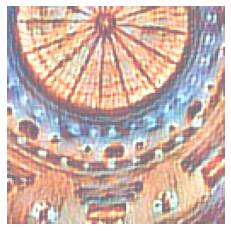

In [49]:
url_example_link = '../../../Dataset/content/Train/4113409291_dc969c8941_m.jpg'
get_prediction(img_path=url_example_link, 
               weights_path=night_weights_path,
               use_url_link=False)  # Set use_url_link to False


Original image size: (1, 128, 128, 3)
Padded image size: (1, 384, 384, 3)
padings ((0, 0), (128, 128), (128, 128), (0, 0))
1/1 [==============================] - 0s 421ms/step
Prediction shape (1, 384, 384, 3)
Shape after unpadding (128, 128, 3)


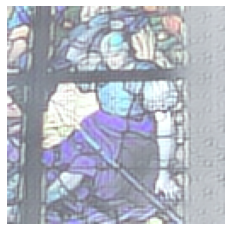

In [50]:
get_prediction(img_path = path_2, weights_path = draft_weights_path)

Original image size: (1, 128, 128, 3)
Padded image size: (1, 384, 384, 3)
padings ((0, 0), (128, 128), (128, 128), (0, 0))
1/1 [==============================] - 0s 416ms/step
Prediction shape (1, 384, 384, 3)
Shape after unpadding (128, 128, 3)


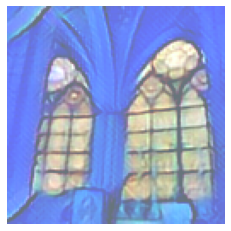

In [51]:
get_prediction(img_path = path_5, weights_path = kandinskiy_weights_path)

Original image size: (1, 128, 128, 3)
Padded image size: (1, 384, 384, 3)
padings ((0, 0), (128, 128), (128, 128), (0, 0))
1/1 [==============================] - 0s 395ms/step
Prediction shape (1, 384, 384, 3)
Shape after unpadding (128, 128, 3)


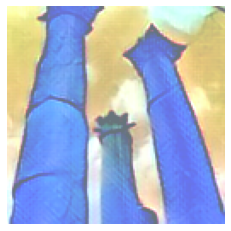

In [54]:
get_prediction(img_path = path_4, weights_path = kandinskiy_weights_path)